na4alo
   Unnamed: 0       ID Case Number                    Date  \
0         879  4786321    HM399414  01/01/2004 12:01:00 AM   
1        2544  4676906    HM278933  03/01/2003 12:00:00 AM   
2        2919  4789749    HM402220  06/20/2004 11:00:00 AM   
3        2927  4789765    HM402058  12/30/2004 08:00:00 PM   
4        3302  4677901    HM275615  05/01/2003 01:00:00 AM   

                 Block  IUCR                Primary Type  \
0    082XX S COLES AVE  0840                       THEFT   
1      004XX W 42ND PL  2825               OTHER OFFENSE   
2  025XX N KIMBALL AVE  1752  OFFENSE INVOLVING CHILDREN   
3   045XX W MONTANA ST  0840                       THEFT   
4   111XX S NORMAL AVE  0841                       THEFT   

                      Description Location Description  Arrest  ...  Ward  \
0   FINANCIAL ID THEFT: OVER $300            RESIDENCE   False  ...   7.0   
1         HARASSMENT BY TELEPHONE            RESIDENCE   False  ...  11.0   
2   AGG CRIM SEX ABUSE FAM M

C:\Users\Аркадий\AppData\Local\Temp\ipykernel_5980\4210423203.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_by_day.index, y=crime_by_day.values, palette='coolwarm')


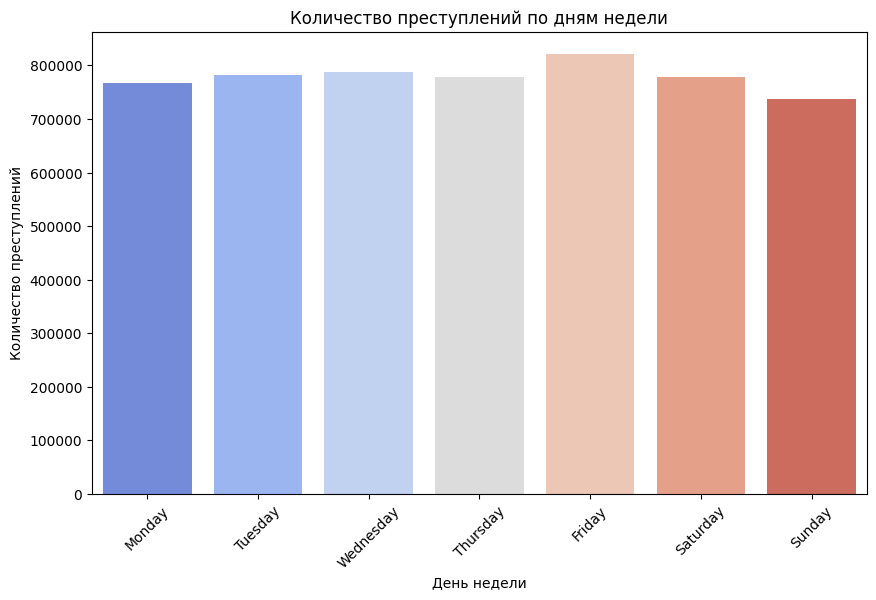

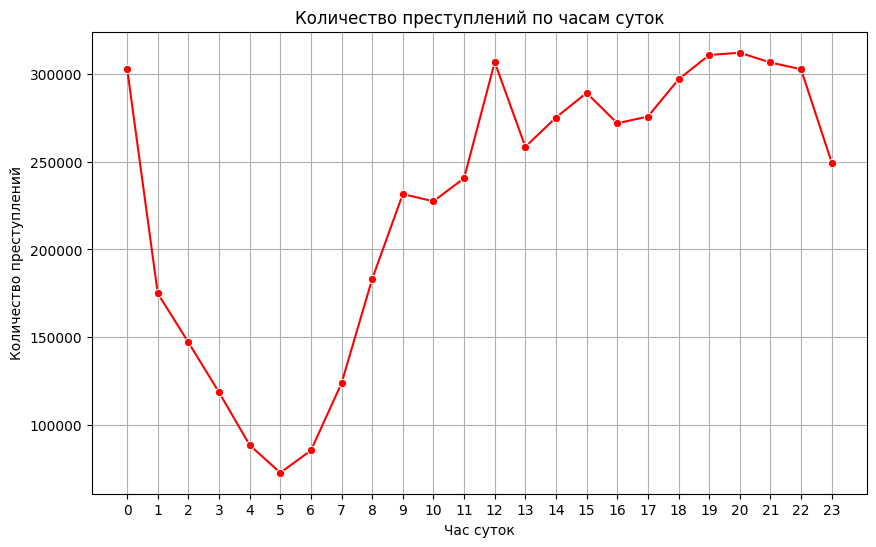

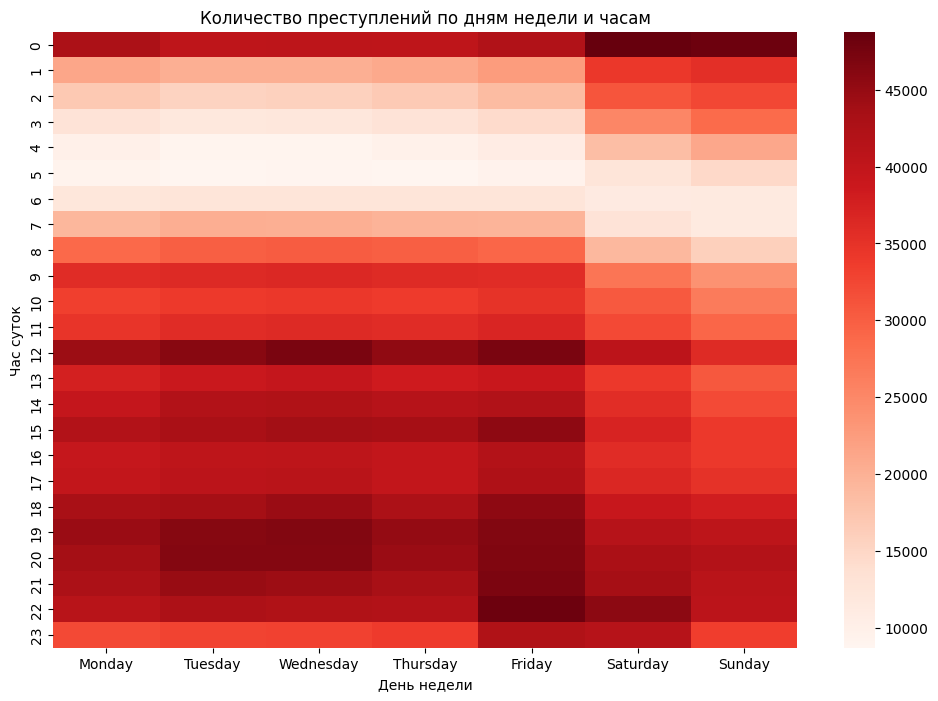

Самый опасный час недели: Saturday в 0:00


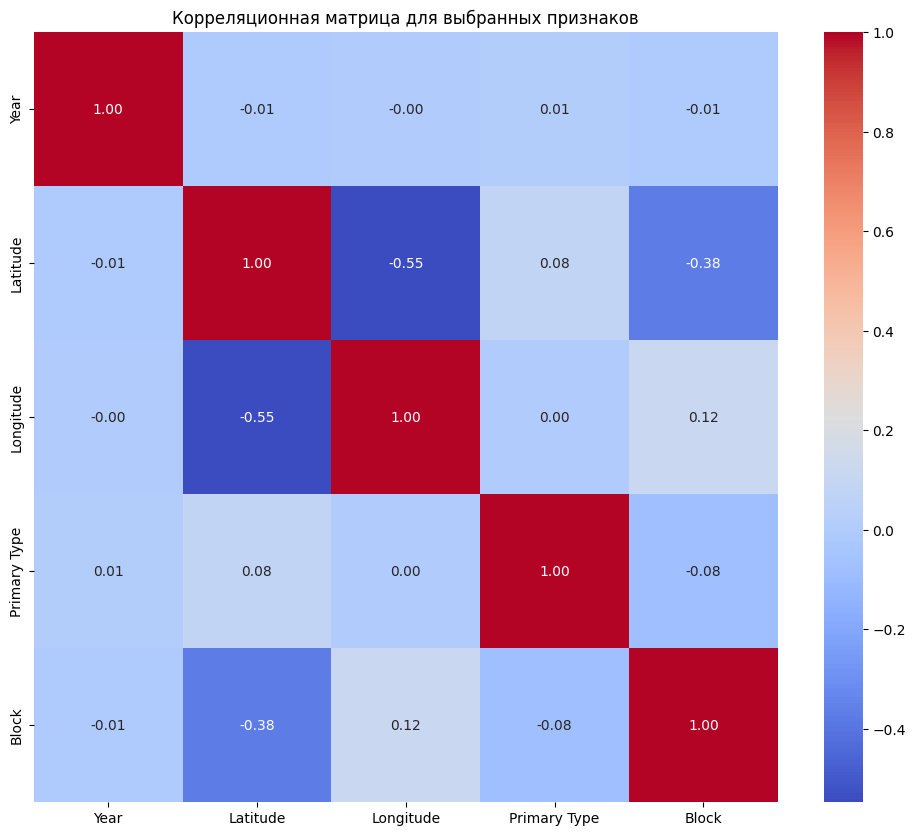

Количество строк после фильтрации: 507785
Средняя точность кросс-валидации: 0.8890652539952931
Разброс точности: 0.010840402728800935
Точность модели: 0.8604921374203649
Конец


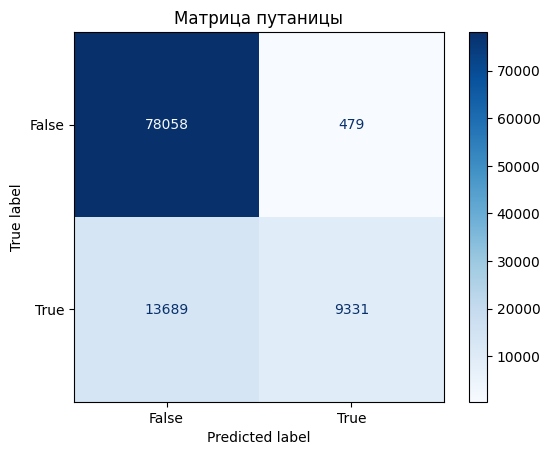

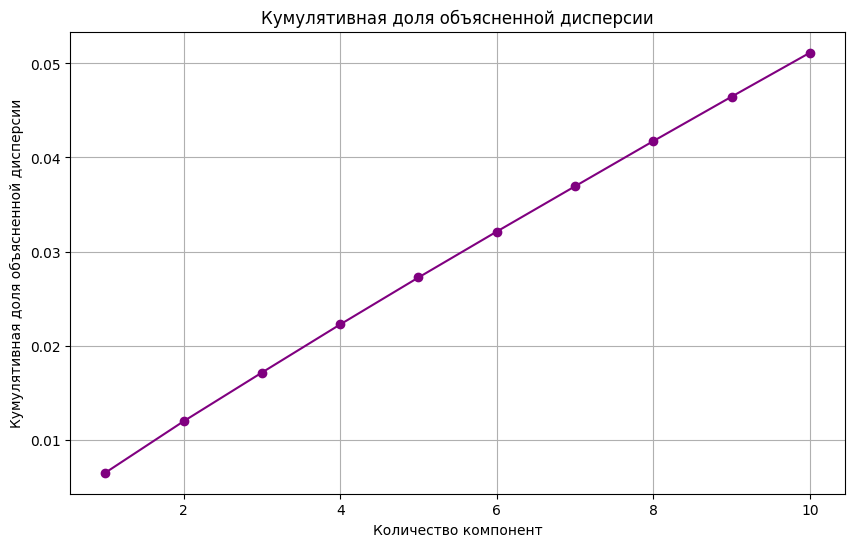

koneccc


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

print('na4alo')
# Загрузка данных
data0 = pd.read_csv('C:/Users/Аркадий/Arhiv/Chicago_Crimes_2001_to_2004.csv', on_bad_lines="skip", low_memory=False)
data1 = pd.read_csv('C:/Users/Аркадий/Arhiv/Chicago_Crimes_2005_to_2007.csv', on_bad_lines="skip", low_memory=False)
data2 = pd.read_csv('C:/Users/Аркадий/Arhiv/Chicago_Crimes_2008_to_2011.csv', on_bad_lines="skip", low_memory=False)
data3 = pd.read_csv('C:/Users/Аркадий/Arhiv/Chicago_Crimes_2012_to_2017.csv', on_bad_lines="skip", low_memory=False)
data = pd.concat([data0, data1, data2, data3], ignore_index=True)

print(data.head())
print(f'Количество строк до чистки: {len(data)}')

# Очистка данных
data = data.dropna()  # Удаляем строки с пропущенными значениями
data.drop_duplicates(inplace=True)  # Удаляем дубликаты

# Удаление выбросов для числовых данных
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

print(f'После удаления выбросов: {len(data)}')

# Очистим данные
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')  # Преобразуем в datetime
data = data.dropna(subset=['Date'])  # Удаляем строки с некорректными датами
data.drop_duplicates(inplace=True)  # Удаляем дубликаты
print('Количество строк после чистки:', len(data))

# Добавляем столбцы для анализа
data['DayOfWeek'] = data['Date'].dt.day_name()
data['Hour'] = data['Date'].dt.hour
data['IsWeekend'] = data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)


# Анализ по дням недели
crime_by_day = data['DayOfWeek'].value_counts()
crime_by_day = crime_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Построим график по дням недели
plt.figure(figsize=(10, 6))
sns.barplot(x=crime_by_day.index, y=crime_by_day.values, palette='coolwarm')
plt.title('Количество преступлений по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество преступлений')
plt.xticks(rotation=45)
plt.show()

# Анализ по часам
crime_by_hour = data['Hour'].value_counts().sort_index()

# Построим график по часам суток
plt.figure(figsize=(10, 6))
sns.lineplot(x=crime_by_hour.index, y=crime_by_hour.values, marker='o', color='red')
plt.title('Количество преступлений по часам суток')
plt.xlabel('Час суток')
plt.ylabel('Количество преступлений')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Анализ по дням недели и часам
crime_by_day_hour = data.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='CrimeCount')

# Упорядочим дни недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_by_day_hour['DayOfWeek'] = pd.Categorical(crime_by_day_hour['DayOfWeek'], categories=day_order, ordered=True)

# Построим тепловую карту
pivot_table = crime_by_day_hour.pivot(index='Hour', columns='DayOfWeek', values='CrimeCount')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='Reds', annot=False, cbar=True)
plt.title('Количество преступлений по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час суток')
plt.show()

# Найдем самый опасный час недели
max_crime = crime_by_day_hour.loc[crime_by_day_hour['CrimeCount'].idxmax()]
most_dangerous_time = f"{max_crime['DayOfWeek']} в {max_crime['Hour']}:00"
print(f"Самый опасный час недели: {most_dangerous_time}")

# Оценка корреляции данных
# Выбор только числовых и необходимых категориальных столбцов
categorical_columns = ['Primary Type', 'Block']
numeric_columns = ['Year', 'Latitude', 'Longitude']

# Создание копии данных для преобразования
data_transformed = data.copy()

# Преобразование категориальных переменных в числовые
label_encoder = LabelEncoder()
for col in categorical_columns:
    data_transformed[col] = label_encoder.fit_transform(data_transformed[col])

# Удаление ненужных столбцов
columns_to_drop = ['Unnamed: 0', 'Case Number', 'Updated On', 'Location', 'Date']
data_transformed = data_transformed.drop(columns=columns_to_drop, errors='ignore')

# Фильтрация данных: только полезные признаки
columns_to_keep = numeric_columns + categorical_columns
data_transformed = data_transformed[columns_to_keep]

# Создание корреляционной матрицы
correlation_matrix = data_transformed.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Корреляционная матрица для выбранных признаков')
plt.show()



# Преобразование столбца 'Date' в формат datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Извлечение года из столбца 'Date' в новый столбец 'Year'
data['Year'] = data['Date'].dt.year

# Фильтрация данных по году
data = data[data['Year'] >= 2015]

print(f"Количество строк после фильтрации: {len(data)}")

# Очистка данных
data = data.dropna()  # Удаляем строки с пропущенными значениями
data.drop_duplicates(inplace=True)  # Удаляем дубликаты

# Удаление ненужных столбцов
irrelevant_columns = ['ID', 'Case Number', 'Date', 'Block', 'Updated On', 'Location']
data = data.drop(columns=irrelevant_columns, errors='ignore')


# Заполнение пропусков в числовых столбцах
data['Y Coordinate'] = pd.to_numeric(data['Y Coordinate'], errors='coerce')
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
data['Y Coordinate'] = data['Y Coordinate'].fillna(data['Y Coordinate'].mean())
data['Latitude'] = data['Latitude'].fillna(data['Latitude'].mean())

X = data.drop(columns=['Arrest'])  # Признаки
y = data['Arrest']  # Целевая переменная

# Преобразование категориальных переменных в числовые
categorical_columns = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Применяем PCA для уменьшения размерности
pca = PCA(n_components=10)  # Уменьшаем количество компонент до 10
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Обучаем модель логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train_pca, y_train)

# Оценка модели с использованием кросс-валидации
cross_val_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
print(f'Средняя точность кросс-валидации: {cross_val_scores.mean()}')
print(f'Разброс точности: {cross_val_scores.std()}')

# Предсказание и оценка модели
y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')
print('Конец')

# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Матрица путаницы')
plt.show()


# Кумулятивная доля объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', color='purple')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная доля объясненной дисперсии')
plt.title('Кумулятивная доля объясненной дисперсии')
plt.grid()
plt.show()

print('koneccc')